In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import *

from cpcv_util import *

,x,y,y_noise
0,-10.000000,0.544021,0.890357
1,-9.998000,0.542342,0.756545
2,-9.996000,0.540660,0.732369
3,-9.993999,0.538976,0.802697
4,-9.991999,0.537291,0.681080
...,...,...,...
9995,9.991999,-0.537291,-0.595585
9996,9.993999,-0.538976,-0.931827
9997,9.996000,-0.540660,-0.233307
9998,9.998000,-0.542342,-0.799162


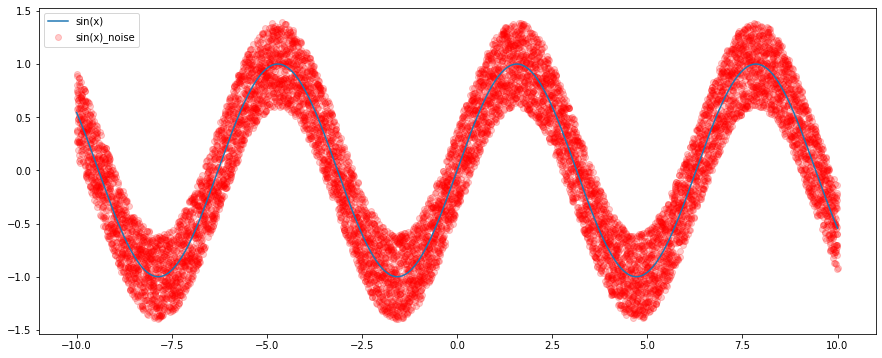

In [2]:
sample_size = 10000
x = np.linspace(-10, 10, sample_size)
y = np.sin(x)
y_noise = y + np.random.uniform(-0.4, 0.4, sample_size)

df = pd.DataFrame({'x': x, 'y': y, 'y_noise': y_noise})

plt.figure(figsize=[15, 6])
plt.plot(df['x'], df['y'], label='sin(x)')
plt.scatter(df['x'], df['y_noise'], label='sin(x)_noise', color='red', alpha=0.2)
plt.legend()

display(df)

In [3]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}

y_preds = np.zeros((10000, 3))
quantiles = [.1, .5, .9]
x_train, y = x.reshape(-1, 1), y_noise

for i in range(len(quantiles)):
    print('prediction of quantile', quantiles[i])
    lgbr = LGBMRegressor(alpha=quantiles[i], **params)
    model = lgbr.fit(df[['x']], df['y_noise'])
    y_preds[:, i] = model.predict(x_train)

prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9


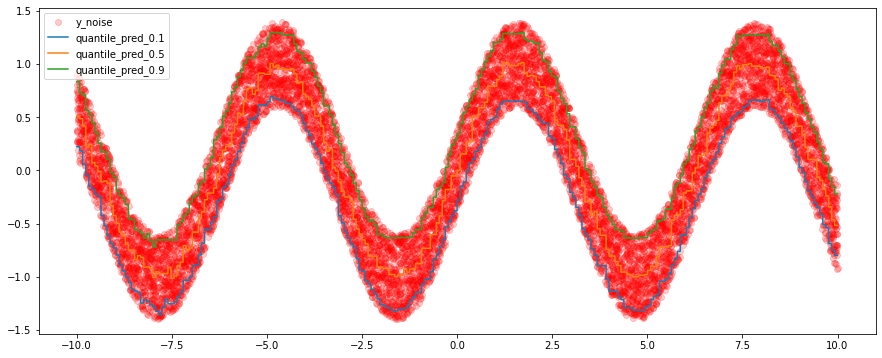

In [4]:
plt.figure(figsize=[15, 6])

plt.scatter(x, y_noise, label='y_noise', alpha=.2, color='red')
for i in range(len(quantiles)):
    plt.plot(x, y_preds[:, i], label='quantile_pred_{}'.format(quantiles[i]))
plt.legend()

In [5]:
import optuna
import optuna.integration.lightgbm as lgb_optuna

# 固定するLightGBMのパラメータ
train_fixed_params = {
    'objective':'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'extra_trees': True,
    'deterministic': True,
    'force_row_wise': True,
    'num_threads': 8
}

# Optunaを使って最適パラメータを探しながらモデルをトレーニングする関数
def optuna_optimize_cv(df_train=None, df_target=None, folds=None, params=None):
    optuna.logging.set_verbosity(optuna.logging.ERROR)
    
    # トレーニングデータをLightGBMで使う形式に変換
    lgb_train_data = lgb_optuna.Dataset(df_train, df_target, free_raw_data=False)
    
    # 与えられたfoldを利用して、CVを使った学習を行う
    optuna_search = optuna.integration.LightGBMTunerCV(params,
                                                       train_set = lgb_train_data,
                                                       folds = folds,
                                                       early_stopping_rounds = 100,
                                                       verbose_eval = 0,
                                                       show_progress_bar = False,
                                                       optuna_seed = 47,
                                                       return_cvbooster = True)
    optuna_search.run()        
    return optuna_search.get_best_booster(), optuna_search.best_params

# 特徴量はxのみ
features = ['x']

# CPCVを使ったハイパーパラメータチューニングとモデルトレーニングを開始
folds = cpcv_split(df)
display(folds)
model_cv, model_param_cv = optuna_optimize_cv(df[features], df['y_noise'], folds, train_fixed_params)

[(array([   0,    1,    2, ..., 6465, 6466, 6467]),
  array([6668, 6669, 6670, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 8131, 8132, 8133]),
  array([5001, 5002, 5003, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([5001, 5002, 5003, ..., 8331, 8332, 8333])),
 (array([   0,    1,    2, ..., 8131, 8132, 8133]),
  array([3334, 3335, 3336, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([3334, 3335, 3336, ..., 8331, 8332, 8333])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([3334, 3335, 3336, ..., 6665, 6666, 6667])),
 (array([   0,    1,    2, ..., 8131, 8132, 8133]),
  array([1667, 1668, 1669, ..., 9997, 9998, 9999])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([1667, 1668, 1669, ..., 8331, 8332, 8333])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  array([1667, 1668, 1669, ..., 6665, 6666, 6667])),
 (array([   0,    1,    2, ..., 9997, 9998, 9999]),
  a

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is d

In [6]:
# 真値と予測値を比較して表示するためのユーティリティ関数
def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(17):
        _df = df[(df['pred'] >= pred_min + 0.5 * pred_std * i) & (df['pred'] >= pred_min + 0.5 * pred_std * (i + 1))]
        pred_sections.append(pred_min + pred_std*i)
        true_means.append(_df['true'].mean())

    # 散布図をプロットする (予測対象にならなかったtrue値は0になっているのでそれを除外していることに注意)
    #ax[0, 0].scatter(df.loc[df['true'] != 0,'pred'], df.loc[df['true'] != 0, 'true'], s = 1)
    ax[0, 0].scatter(df['pred'], df['true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='pre')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    ax[0, 0].set_xticks([pred_mean, pred_mean - 2*pred_std, pred_mean - 4*pred_std, pred_mean + 2*pred_std, pred_mean + 4*pred_std])
    ax[0, 0].set_yticks([true_mean, true_mean - 2*true_std, true_mean - 4*true_std, true_mean + 2*true_std, true_mean + 4*true_std])
    ax[0, 0].grid(axis = 'both')
    ax[0, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    ax[0, 0].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    # 0と予測した値を表示するとヒストグラムがまともに見えないので除外している
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])
    ax[1, 0].grid(axis = 'both')
    ax[1, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    ax[0, 1].grid(axis = 'both')
    ax[0, 1].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[1, 1].remove()
    
    fig.show()

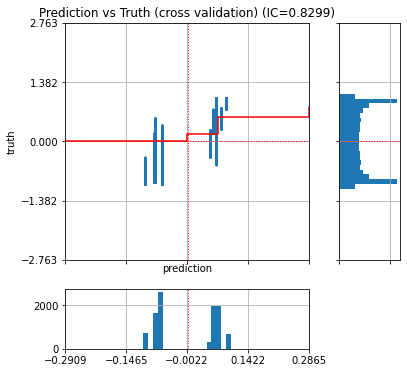

In [7]:
# 学習区間について予測を行い、学習したモデルの性能を確認する
df_predict = pd.DataFrame(model_cv.predict(df[features], num_iteration=model_cv.best_iteration))
df_predict = df_predict.transpose()
for index, fold in enumerate(folds):
    df_predict.iloc[fold[1], index] = np.nan
df['y_pred'] = df_predict.mean(axis=1)

# 真値と予測値の関係を見る
display_true_vs_pred(df['y'], df['y_pred'], 'Prediction vs Truth (cross validation)')

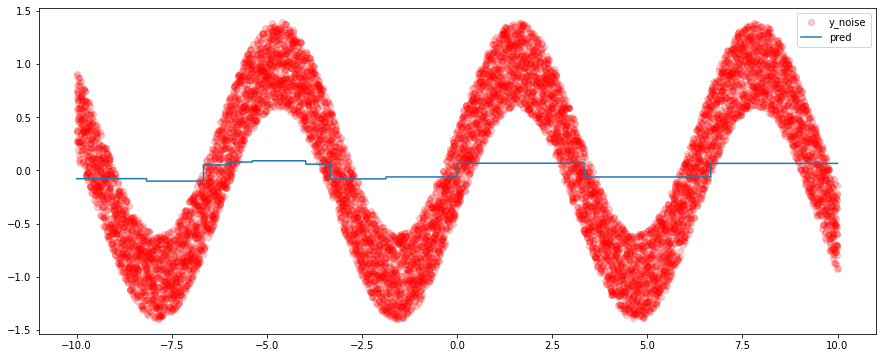

In [8]:
plt.figure(figsize=[15, 6])

plt.scatter(x, y_noise, label='y_noise', alpha=.2, color='red')
plt.plot(x, df['y_pred'], label='pred')
plt.legend()

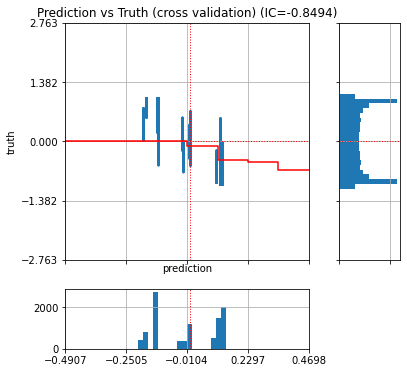

In [9]:
# バリデーション区間について予測を行い、学習したモデルの性能を確認する
df_predict = pd.DataFrame(model_cv.predict(df[features], num_iteration=model_cv.best_iteration))
df_predict = df_predict.transpose()
for index, fold in enumerate(folds):
    df_predict.iloc[fold[0], index] = np.nan
df['y_pred'] = df_predict.mean(axis=1)

# 真値と予測値の関係を見る
display_true_vs_pred(df['y'], df['y_pred'], 'Prediction vs Truth (cross validation)')

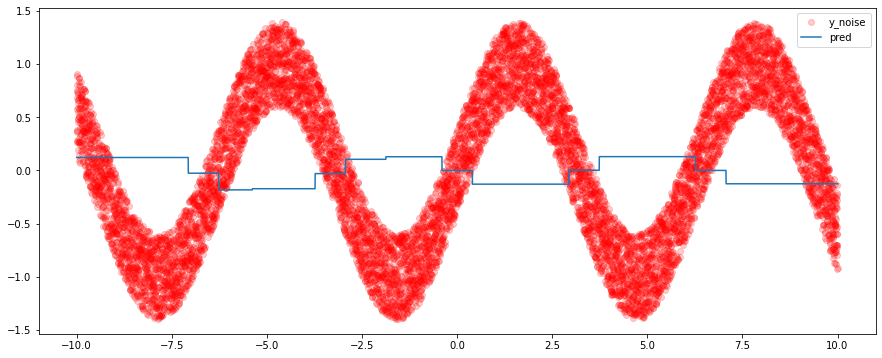

In [10]:
plt.figure(figsize=[15, 6])

plt.scatter(x, y_noise, label='y_noise', alpha=.2, color='red')
plt.plot(x, df['y_pred'], label='pred')
plt.legend()